In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from pprint import pprint

In [2]:
# read in the csv
all_seasons = pd.read_csv("resources/all_seasons.csv").set_index('player_name')

# set up the removal and renaming of columns 
remove_columns = ['Unnamed: 0']
rename_columns = {'team_abbreviation': 'Team Abbreviation'
                  ,'age': 'Age'
                  ,'player_height': 'Player Height'
                  ,'player_weight': 'Player Weight'
                  ,'college': 'College'
                  ,'country': 'Country'
                  ,'draft_year': 'Draft Year'
                  ,'draft_round': 'Draft Round'
                  ,'draft_number': 'Draft Number'
                  ,'gp': 'Games Played'
                  ,'pts': 'Points'
                  ,'reb': 'Rebounds'
                  ,'ast': 'Assists'
                  ,'net_rating': 'Net Rating'
                  ,'oreb_pct': 'Offensive Rebound Percentage'
                  ,'dreb_pct': 'Defensive Rebound Percentage'
                  ,'usg_pct': 'Usage Percentage'
                  ,'ts_pct': 'True Shooting Percentage'
                  ,'ast_pct': 'Assist Percentage'
                  ,'season': 'Season'}
all_seasons = all_seasons.drop(columns = remove_columns)
all_seasons = all_seasons.rename(columns = rename_columns)

# set the index
all_seasons.index.name = 'Player Name'

#remove any data that is outside of our date range then store in CSV file
all_seasons = all_seasons[(all_seasons['Season'].str[:4] >= '2000') & (all_seasons['Season'].str[:4] <= '2020')]
all_seasons = all_seasons.to_csv("resources/all_seasons_revised.csv")


In [3]:
# read the created CSV and print the results
seasons_2000_2020_df = pd.DataFrame(pd.read_csv("resources/all_seasons_revised.csv"))
seasons_2000_2020_df.head()

,Player Name,Team Abbreviation,Age,Player Height,Player Weight,College,Country,Draft Year,Draft Round,Draft Number,...,Points,Rebounds,Assists,Net Rating,Offensive Rebound Percentage,Defensive Rebound Percentage,Usage Percentage,True Shooting Percentage,Assist Percentage,Season
0,Jermaine O'Neal,IND,22.0,210.82,102.511792,NaN,USA,1996,1,17,...,12.9,9.8,1.2,0.7,0.111,0.220,0.214,0.501,0.066,2000-01
1,Jerome Kersey,MIL,39.0,200.66,97.522280,Longwood,USA,1984,2,46,...,3.3,2.0,0.7,1.3,0.036,0.196,0.150,0.473,0.098,2000-01
2,Jason Williams,SAC,25.0,185.42,86.182480,Florida,USA,1998,1,7,...,9.4,2.4,5.4,5.4,0.009,0.075,0.167,0.498,0.256,2000-01
3,Jelani McCoy,SEA,23.0,208.28,111.130040,UCLA,USA,1998,2,33,...,4.5,3.6,0.8,-4.2,0.091,0.153,0.155,0.520,0.082,2000-01
4,Jeff McInnis,LAC,26.0,193.04,80.739376,North Carolina,USA,1996,2,37,...,12.9,2.7,5.5,-5.5,0.017,0.071,0.183,0.521,0.270,2000-01


In [10]:
# find different values - unique players, minimum and maximum age, count of teams, total games played
unique_players = pd.DataFrame(seasons_2000_2020_df['Player Name'].unique(), columns = ['Player Name'])
age_range_by_player = pd.DataFrame(seasons_2000_2020_df.groupby('Player Name')['Age'].agg(['min', 'max']))
team_count_by_player = pd.DataFrame(seasons_2000_2020_df.groupby('Player Name')['Team Abbreviation'].nunique())
total_games_by_player = pd.DataFrame(seasons_2000_2020_df.groupby('Player Name')['Games Played'].sum())

# find a players last team
last_team_by_player = seasons_2000_2020_df.sort_values('Season', ascending = False)
last_team_by_player = last_team_by_player.drop_duplicates(subset = 'Player Name', keep = 'first')
last_team_by_player = pd.DataFrame(last_team_by_player[['Player Name', 'Team Abbreviation']])
last_team_by_player = last_team_by_player.rename(columns = {'Team Abbreviation': 'Last Team'})

# find the number of seasons a player was in (ensure to remove duplicates for and team transfers)
season_count = pd.DataFrame(seasons_2000_2020_df[['Player Name', 'Season']].copy())
season_count = season_count.drop_duplicates(subset = ['Player Name', 'Season'])
season_count = season_count.groupby('Player Name').size().reset_index(name = 'Season Count')

# calculate all of the averages 
mean_numbers = ['Points', 'Rebounds', 'Assists', 'Offensive Rebound Percentage', 
                'Defensive Rebound Percentage', 'Usage Percentage', 'True Shooting Percentage', 
                'Assist Percentage', 'Player Height', 'Player Weight', 'Net Rating']
points = pd.DataFrame(seasons_2000_2020_df.groupby('Player Name')[mean_numbers].mean())

# store the static data (mostly their draft information and background)
static_data = seasons_2000_2020_df[['Player Name', 'College', 'Country', 'Draft Year', 'Draft Round', 'Draft Number']].copy()
static_data = static_data.drop_duplicates(subset = 'Player Name')

# merge the dataframes
merged_df = pd.merge(unique_players, season_count, on = 'Player Name', how = 'left')
merged_df = pd.merge(merged_df, age_range_by_player, on = 'Player Name', how = 'left')
merged_df = pd.merge(merged_df, team_count_by_player, on = 'Player Name', how = 'left')
merged_df = pd.merge(merged_df, total_games_by_player, on = 'Player Name', how = 'left')
merged_df = pd.merge(merged_df, points, on = 'Player Name', how = 'left')
merged_df = pd.merge(static_data, merged_df, on = 'Player Name', how = 'left')
merged_df = pd.merge(merged_df, last_team_by_player, on = 'Player Name', how = 'left')

#formatting
new_columns = {'min': 'Min Age', 'max': 'Max Age', 'Team Abbreviation': 'Team Count', 'Games Played': 'Total Games'}
merged_df = merged_df.rename(columns = new_columns)
merged_df = merged_df.set_index('Player Name')

# store data in csv and print results
merged_df.to_csv("resources/player_stats_2000-2020.csv")
merged_df.head()
unique_players


,Player Name
0,Jermaine O'Neal
1,Jerome Kersey
2,Jason Williams
3,Jelani McCoy
4,Jeff McInnis
...,...
2056,Malachi Flynn
2057,Malik Fitts
2058,Mamadi Diakite
2059,Markus Howard


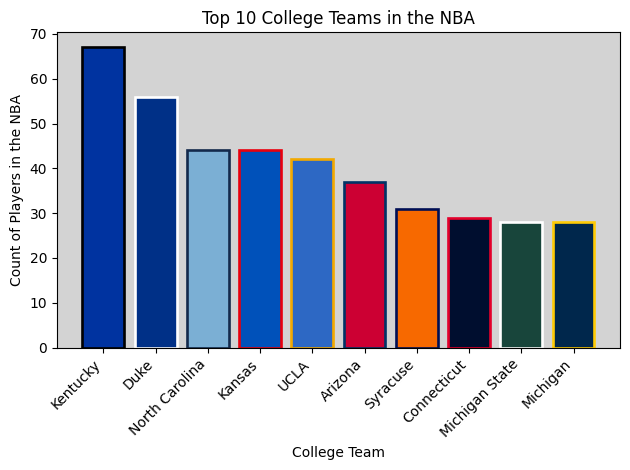

In [9]:
colleges = merged_df.groupby('College').size().reset_index(name = 'Count of Players')
colleges_sorted = pd.DataFrame(colleges.sort_values(by = 'Count of Players', ascending = False).head(10))
colleges_sorted.set_index('College')

college_x_axis = colleges_sorted['College']
college_y_axis = colleges_sorted['Count of Players']

college_colors = pd.DataFrame(pd.read_csv("resources/college_hex_colors.csv"))
primary_color = college_colors['Hex_1']
secondary_color = college_colors['Hex_2']

plt.bar(college_x_axis, college_y_axis, color = primary_color, edgecolor = secondary_color, linewidth = 1.9)

plt.gca().set_facecolor('lightgrey')

plt.xlabel('College Team')
plt.ylabel('Count of Players in the NBA')
plt.title('Top 10 College Teams in the NBA')
# rotation and horizontal alignment
plt.xticks(college_x_axis, rotation = 45, ha='right')
plt.tight_layout()

plt.savefig('figures/college_to_NBA.png')
plt.show()

In [6]:
career_by_college = merged_df.reset_index()[['Player Name', 'College', 'Season Count', 'Total Games']].copy()
career_by_college = pd.DataFrame(career_by_college.groupby('College')[['Season Count', 'Total Games']].mean())
career_by_college = pd.merge(career_by_college, colleges[['College', 'Count of Players']], on='College', how='left')

player_bins = [0, 5, 10, 15, 20, 25, 70]
player_labels = ['<5', '5-10', '10-15', '15-20', '20-25', 'Top 10 Colleges']

player_career_df = career_by_college.copy()
player_career_df['Player Bins'] = pd.cut(player_career_df['Count of Players'], bins=player_bins ,labels=player_labels ,include_lowest=True)
college_by_bin = pd.DataFrame(player_career_df.groupby('Player Bins')['College'].count())


player_career_final_df = pd.DataFrame(player_career_df.groupby('Player Bins')[['Season Count', 'Total Games']].mean())
player_career_final_df = pd.merge(player_career_final_df, college_by_bin, on = 'Player Bins', how = 'left')

final_df_new_columns = {'Player Bins': 'Count of Players', 'Season Count': 'AVG Seasons Played', 'Total Games': 'AVG Games', 'College': 'Count of Colleges'}
player_career_final_df = player_career_final_df.reset_index().rename(columns = final_df_new_columns)
player_career_final_df = player_career_final_df.set_index('Count of Players')
player_career_final_df


,AVG Seasons Played,AVG Games,Count of Colleges
Count of Players,,,
<5,3.972356,188.154888,208
5-10,4.295635,214.774221,28
10-15,4.659955,240.257816,20
15-20,4.634118,235.632981,13
20-25,4.886000,255.791220,11
Top 10 Colleges,5.612672,308.522606,10


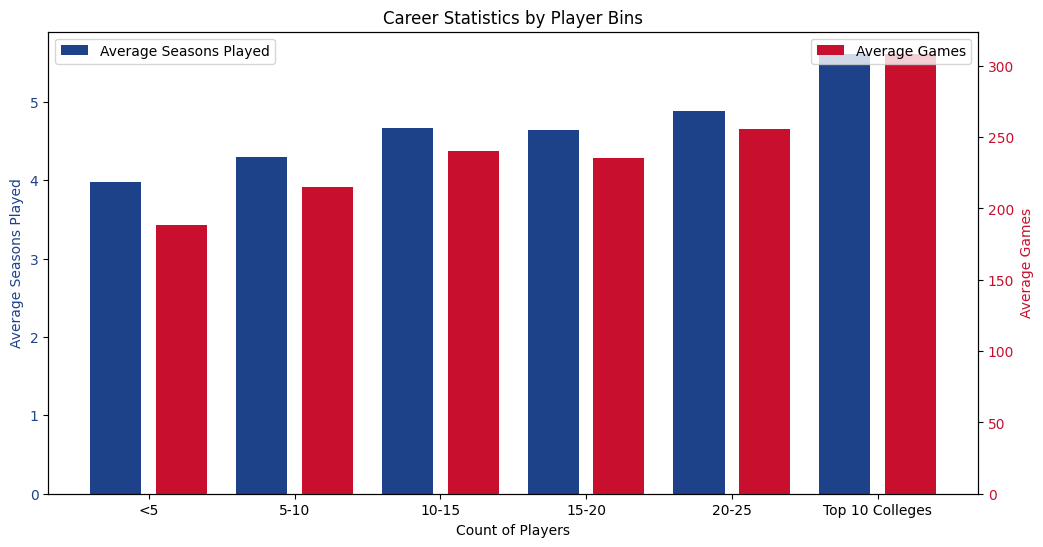

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a numeric index for plotting
numeric_index = np.arange(len(player_career_final_df))

# Define the width of the bars and the spacing between them
bar_width = 0.35
bar_spacing = 0.10  # Adjust the spacing as needed

nba_color_one = '#1D428A'
nba_color_two = '#C8102E'

# Plotting average seasons played on the left axis
ax1.bar(
    numeric_index - (bar_width + bar_spacing) / 2,
    player_career_final_df['AVG Seasons Played'],
    width=bar_width,
    color=nba_color_one,
    label='Average Seasons Played'
)


ax1.set_xlabel('Count of Players')
ax1.set_ylabel('Average Seasons Played', color=nba_color_one)
ax1.tick_params(axis='y', labelcolor = nba_color_one)
ax1.legend(loc='upper left')

# Creating a second y-axis for average games
ax2 = ax1.twinx()
ax2.bar(
    numeric_index + (bar_width + bar_spacing) / 2,
    player_career_final_df['AVG Games'],
    width=bar_width,
    color=nba_color_two,
    label='Average Games'
)
ax2.set_ylabel('Average Games', color=nba_color_two)
ax2.tick_params(axis='y', labelcolor=nba_color_two)
ax2.legend(loc='upper right')

# Set x-axis ticks and labels
ax1.set_xticks(numeric_index)
ax1.set_xticklabels(player_career_final_df.index)

# Display the plot
plt.title('Career Statistics by Player Bins')
plt.savefig('figures/player_college_bins-in_NBA.png')
plt.show()